<a href="https://colab.research.google.com/github/RMSCRV/IB2AD/blob/main/ml_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project: IB2AD Exam

**Author:** U5593619  
**Date:** 05/12/2025  
**Objective:** California Housing Price Prediction using both regression and classification approaches
---

### Table of Contents
1. [Setup & Imports](#setup)
2. [Data Loading & Exploration](#exploration)
3. [Data Cleaning](#cleaning)
4. [Feature Engineering](#features)
5. [Model Training](#training)
6. [Model Evaluation & Comparison](#evaluation)
7. [Results & Insights](#results)
---

## 1. Setup & Imports

### 1.1 Import Libraries

In [194]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn - Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Scikit-learn - Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

# Scikit-learn - Metrics
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                              accuracy_score, precision_recall_fscore_support,
                              ConfusionMatrixDisplay, classification_report, confusion_matrix)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Data Loading
from sklearn.datasets import fetch_california_housing

# Utilities
import os
import pickle
from datetime import datetime
from scipy.stats import uniform, randint

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"PyTorch version: {torch.__version__}")

All libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.2.2
PyTorch version: 2.9.0+cu126


### 1.2 Configuration

In [195]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# File paths (for local save, Colab will use current directory)
DATA_RAW_PATH = './data/raw/'
DATA_PROCESSED_PATH = './data/processed/'
MODELS_PATH = './models/'
FIGURES_PATH = './figures/'

# Create directories
for path in [DATA_RAW_PATH, DATA_PROCESSED_PATH, MODELS_PATH, FIGURES_PATH]:
    os.makedirs(path, exist_ok=True)

# Model parameters
TEST_SIZE = 0.2
N_BINS = 5  # Number of bins for converting regression to classification

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Configuration complete!")
print(f"Random seed: {RANDOM_SEED}")
print(f"Test size: {TEST_SIZE}")
print(f"Number of bins for classification: {N_BINS}")

Configuration complete!
Random seed: 42
Test size: 0.2
Number of bins for classification: 5


### 1.3 Helper Functions

In [196]:
def print_section_header(title, char='='):
    """Print formatted section header"""
    print(f"\n{char * 80}")
    print(f"{title.center(80)}")
    print(f"{char * 80}\n")

def bin_continuous_target(y, n_bins=5):
    """
    Bin continuous target into n equal bins for classification

    Parameters:
    -----------
    y : array-like
        Continuous target values
    n_bins : int
        Number of bins

    Returns:
    --------
    y_binned : array
        Binned target values (0 to n_bins-1)
    bin_edges : array
        Bin edge values for reference
    """
    y_binned, bin_edges = pd.cut(y, bins=n_bins, labels=False, retbins=True)
    return y_binned, bin_edges

def evaluate_regression(y_true, y_pred, model_name="Model"):
    """Calculate and display regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"{'='*50}")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

def evaluate_classification(y_true, y_pred, model_name="Model"):
    """Calculate and display classification metrics including macro averages"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1-score: {f1:.4f}")

    return {'Accuracy': accuracy, 'Macro_Precision': precision,
            'Macro_Recall': recall, 'Macro_F1': f1}

print("Helper functions defined!")

Helper functions defined!


## 2. Data Loading & Exploration
We'll use the California Housing dataset, which contains information about housing districts in California from the 1990 census.

### 2.1 Load Dataset

In [197]:
# Load dataset
housing_data = fetch_california_housing(as_frame=True)
df = housing_data.frame

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]-1}")
print("\nFirst 5 rows:")
display(df.head())
print("\nLast 5 rows:")
display(df.tail())

Dataset loaded successfully!

Dataset shape: (20640, 9)
Number of samples: 20,640
Number of features: 8

First 5 rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Last 5 rows:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


### 2.2 Statistical Summary

### 2.3 Missing Values Analysis

In [198]:
# Check for missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0]

if len(missing_data) > 0:
    print("Missing Values Summary:")
    display(missing_data)
else:
    print("✓ No missing values found in the dataset!")

print(f"\nTotal missing values: {df.isnull().sum().sum()}")

✓ No missing values found in the dataset!

Total missing values: 0


### 2.4 Distribution Analysis

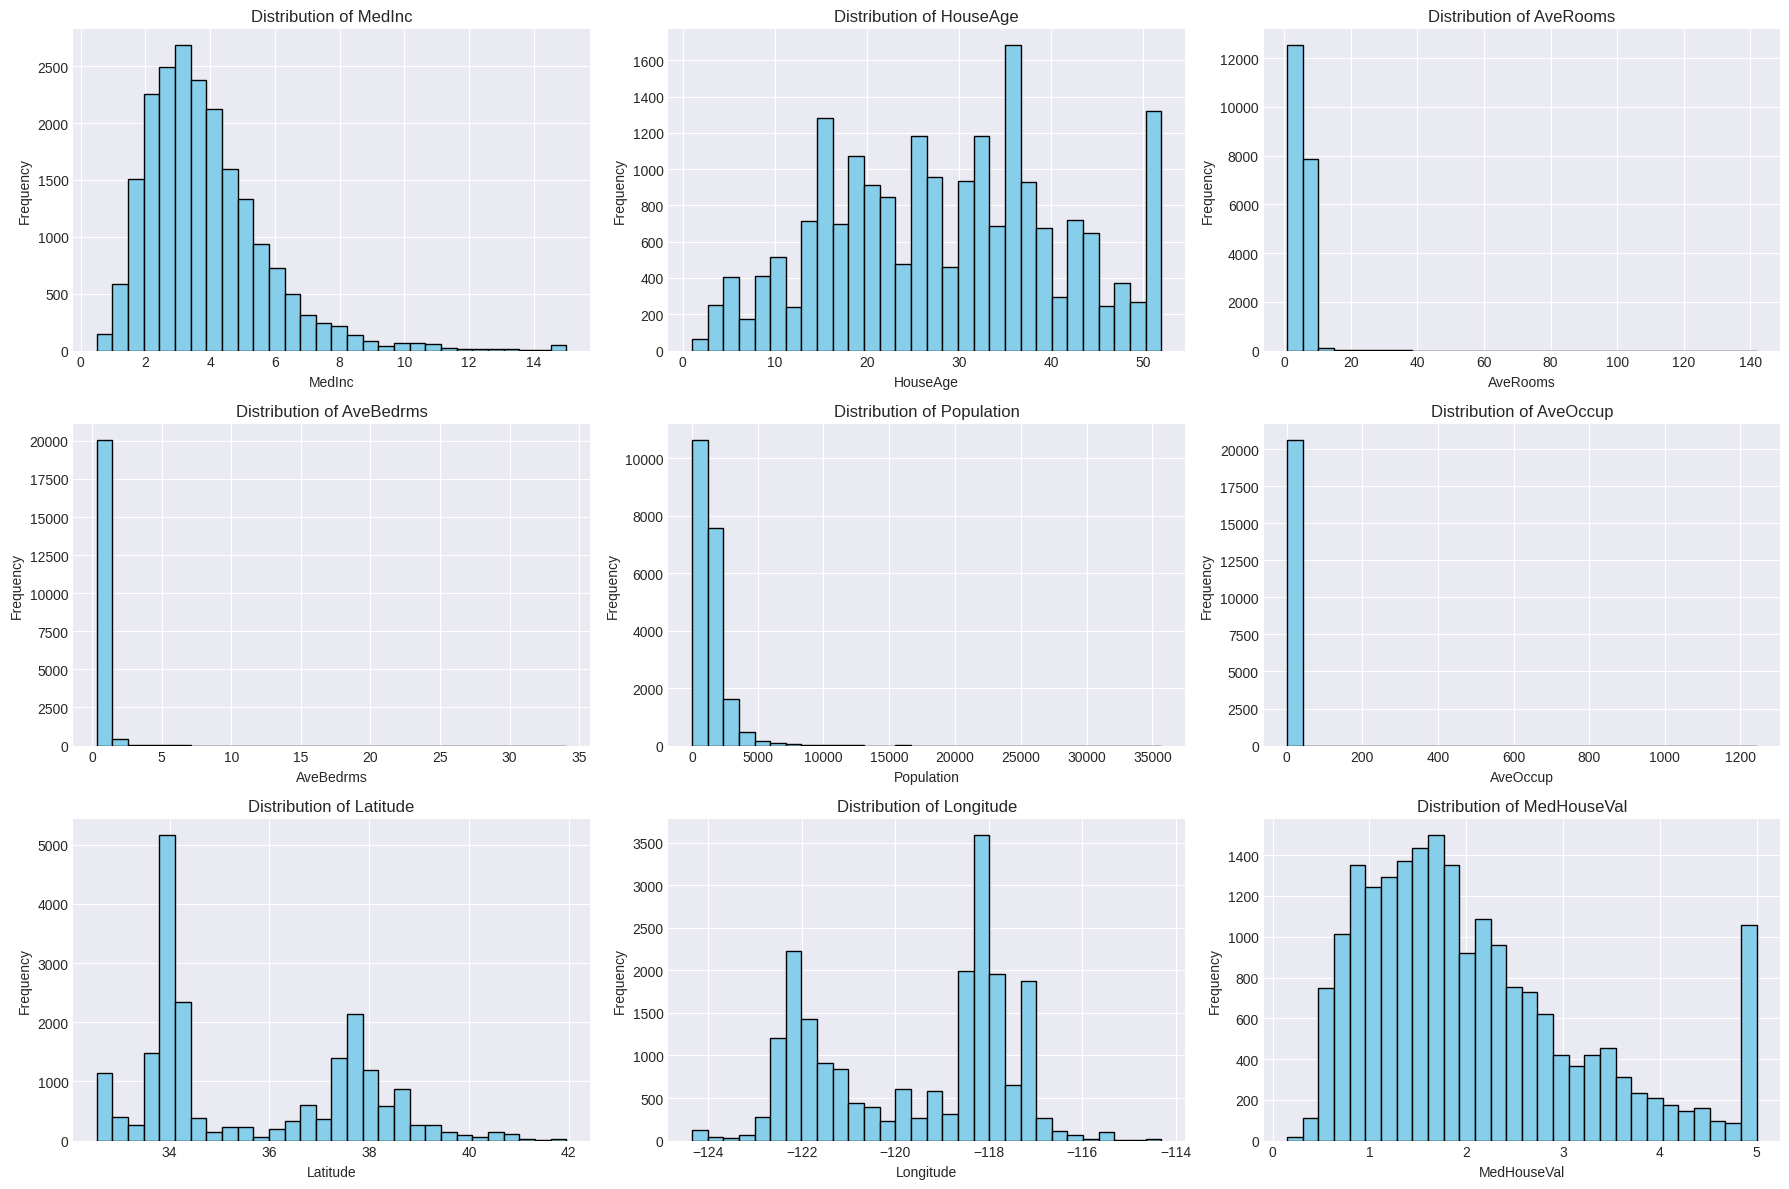


Skewness of Features:
MedInc              :   1.647 (Right-skewed)
HouseAge            :   0.060 (Approximately symmetric)
AveRooms            :  20.698 (Right-skewed)
AveBedrms           :  31.317 (Right-skewed)
Population          :   4.936 (Right-skewed)
AveOccup            :  97.640 (Right-skewed)
Latitude            :   0.466 (Approximately symmetric)
Longitude           :  -0.298 (Approximately symmetric)
MedHouseVal         :   0.978 (Right-skewed)


In [199]:
# Plot distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
for idx, col in enumerate(df.columns):
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Check skewness
print("\nSkewness of Features:")
print("="*50)
for feature in df.columns:
    skew = df[feature].skew()
    skew_type = "Right-skewed" if skew > 0.5 else "Left-skewed" if skew < -0.5 else "Approximately symmetric"
    print(f"{feature:20s}: {skew:7.3f} ({skew_type})")

### 2.5 Correlation Analysis

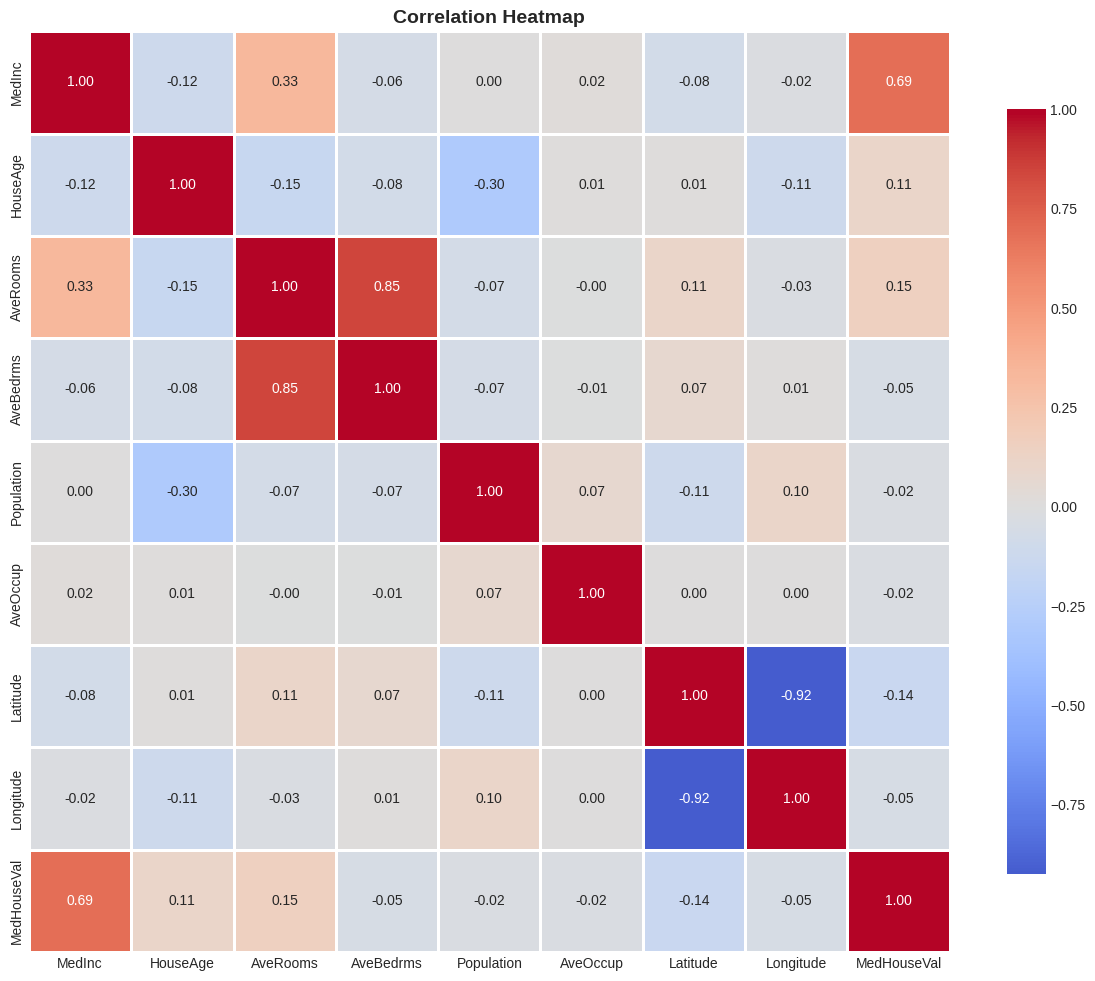


Correlation with MedHouseVal:
MedHouseVal         :  1.0000
MedInc              :  0.6881
AveRooms            :  0.1519
HouseAge            :  0.1056
AveOccup            : -0.0237
Population          : -0.0246
Longitude           : -0.0460
AveBedrms           : -0.0467
Latitude            : -0.1442


In [200]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation with target
target_col = 'MedHouseVal'
correlations = df.corr()[target_col].sort_values(ascending=False)
print(f"\nCorrelation with {target_col}:")
print("="*50)
for feature, corr in correlations.items():
    print(f"{feature:20s}: {corr:7.4f}")

### 2.6 Target Variable Analysis

Target Variable: MedHouseVal
Mean: $2.07 (in $100,000s)
Median: $1.80 (in $100,000s)
Std Dev: $1.15 (in $100,000s)
Min: $0.15 (in $100,000s)
Max: $5.00 (in $100,000s)


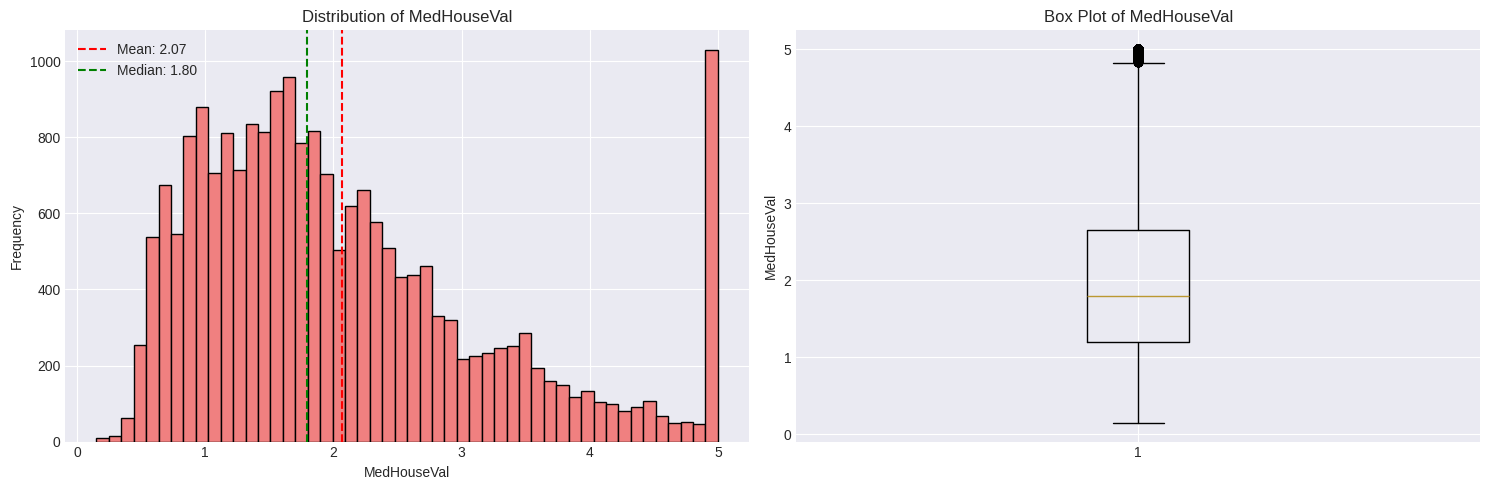

In [201]:
target_col = 'MedHouseVal'
print(f"Target Variable: {target_col}")
print("="*50)
print(f"Mean: ${df[target_col].mean():.2f} (in $100,000s)")
print(f"Median: ${df[target_col].median():.2f} (in $100,000s)")
print(f"Std Dev: ${df[target_col].std():.2f} (in $100,000s)")
print(f"Min: ${df[target_col].min():.2f} (in $100,000s)")
print(f"Max: ${df[target_col].max():.2f} (in $100,000s)")

# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df[target_col], bins=50, edgecolor='black', color='lightcoral')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distribution of {target_col}')
axes[0].axvline(df[target_col].mean(), color='red', linestyle='--',
                label=f'Mean: {df[target_col].mean():.2f}')
axes[0].axvline(df[target_col].median(), color='green', linestyle='--',
                label=f'Median: {df[target_col].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df[target_col])
axes[1].set_ylabel(target_col)
axes[1].set_title(f'Box Plot of {target_col}')
plt.tight_layout()
plt.show()

**Summary of Exploration:**Key findings:- Dataset contains 20,640 samples with 8 features- No missing values present- MedInc (median income) shows the strongest correlation with house values- Some features show right-skewed distributions- Target variable ranges from 0.15 to 5.00 (in $100,000s)---

## 3. Data Cleaning

### 3.1 Handle Missing Values

In [202]:
# Create copy for
cleaningdf_clean = df.copy()
print(f"Total missing values: {df_clean.isnull().sum().sum()}")

Total missing values: 0


### 3.2 Remove Duplicates

In [203]:
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")
else:
    print("No duplicate rows")

print(f"\nDataset shape after removing duplicates: {df_clean.shape}")

Number of duplicate rows: 0
No duplicate rows

Dataset shape after removing duplicates: (20640, 9)


### 3.3 Fix Data Types

In [204]:
print("Current data types:")
print(df_clean.dtypes)
print("\n All data types are correct")

Current data types:
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

 All data types are correct (float64 for regression)!


### 3.4 Handle Outliers

In [205]:
# Analyze outliers using IQR method
print("Outlier Analysis (using IQR method):")
print("="*50)
outlier_counts = {}
for col in df_clean.select_dtypes(include=[np.number]).columns:
  Q1 = df_clean[col].quantile(0.25)
  Q3 = df_clean[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
  outlier_counts[col] = outliers
  percentage = (outliers / len(df_clean)) * 100
  print(f"{col:20s}: {outliers:5d} outliers ({percentage:5.2f}%)")
  print("\n Outliers detected but retained (may represent valid extreme cases)")

Outlier Analysis (using IQR method):
MedInc              :   681 outliers ( 3.30%)

 Outliers detected but retained (may represent valid extreme cases)
HouseAge            :     0 outliers ( 0.00%)

 Outliers detected but retained (may represent valid extreme cases)
AveRooms            :   511 outliers ( 2.48%)

 Outliers detected but retained (may represent valid extreme cases)
AveBedrms           :  1424 outliers ( 6.90%)

 Outliers detected but retained (may represent valid extreme cases)
Population          :  1196 outliers ( 5.79%)

 Outliers detected but retained (may represent valid extreme cases)
AveOccup            :   711 outliers ( 3.44%)

 Outliers detected but retained (may represent valid extreme cases)
Latitude            :     0 outliers ( 0.00%)

 Outliers detected but retained (may represent valid extreme cases)
Longitude           :     0 outliers ( 0.00%)

 Outliers detected but retained (may represent valid extreme cases)
MedHouseVal         :  1071 outliers ( 5.19

### 3.5 Data Validation

In [206]:
# Count negative values
negative_count = (df_clean < 0).sum().sum()
print(f"  Negative values: {negative_count}")

# Count infinite values
inf_count = np.isinf(df_clean.select_dtypes(include=[np.number])).sum().sum()
print(f"  Infinite values: {inf_count}")


  Negative values: 20640
  Infinite values: 0


### 3.6 Save Cleaned Data

In [207]:
# Save cleaned data
cleaned_file_path = os.path.join(DATA_PROCESSED_PATH, 'cleaned_housing_data.csv')
df_clean.to_csv(cleaned_file_path, index=False)

print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Rows: {df_clean.shape[0]:,}")
print(f"Columns: {df_clean.shape[1]}")

display(df_clean.head(10))

Cleaned data saved to: ./data/processed/cleaned_housing_data.csv

Final cleaned dataset shape: (20640, 9)
Rows: 20,640
Columns: 9

Sample of cleaned data:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


## 4. Feature Engineering


### 4.1 Create New Features

In [208]:
# Create copy for feature engineering
df_features = df_clean.copy()
# Feature 1: Rooms per household
df_features['RoomsPerHousehold'] = df_features['AveRooms'] / df_features['AveOccup']

# Feature 2: Bedrooms ratio
df_features['BedroomRatio'] = df_features['AveBedrms'] / df_features['AveRooms']

# Feature 3: Population per household
df_features['PopulationPerHousehold'] = df_features['Population'] / df_features['HouseAge']

# Feature 4: Income per room
df_features['IncomePerRoom'] = df_features['MedInc'] / df_features['AveRooms']

# Replace infinite values
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(df_features.median())
print(f"\nNew shape: {df_features.shape}")
print(f"New features added: {df_features.shape[1] - df_clean.shape[1]}")


New shape: (20640, 13)
New features added: 4


### 4.2 Feature Interactions

In [209]:
# Interaction 1: MedInc * AveRooms
df_features['MedInc_x_AveRooms'] = df_features['MedInc'] * df_features['AveRooms']

# Interaction 2: Latitude * Longitude
df_features['Lat_x_Long'] = df_features['Latitude'] * df_features['Longitude']

### 4.3 Feature Selection

In [210]:
# Separate features and target
X_all = df_features.drop('MedHouseVal', axis=1)
y_continuous = df_features['MedHouseVal']

# Calculate correlation matrix
corr_matrix = X_all.corr().abs()
print(corr_matrix)

# Find highly correlated pairs
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(col, row) for col in upper_triangle.columns
                    for row in upper_triangle.index
                    if upper_triangle.loc[row, col] > 0.95]

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.95):")
    for pair in high_corr_pairs:
        corr_val = corr_matrix.loc[pair[1], pair[0]]
        print(f"  {pair[0]} <-> {pair[1]}: {corr_val:.3f}")
else:
    print("No highly correlated features found!")

print(f"\nFinal feature count: {X_all.shape[1]}")


# Find highly correlated pairs
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(col, row)
                   for col in upper_triangle.columns
                   for row in upper_triangle.index
                   if upper_triangle.loc[row, col] > 0.95]

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.95):")
    for pair in high_corr_pairs:
        corr_val = corr_matrix.loc[pair[1], pair[0]]
        print(f"  {pair[0]} <-> {pair[1]}: {corr_val:.3f}")
else:
    print("No highly correlated features found!")

print(f"\nFinal feature count: {X_all.shape[1]}")


                          MedInc  HouseAge  AveRooms  AveBedrms  Population  \
MedInc                  1.000000  0.119034  0.326895   0.062040    0.004834   
HouseAge                0.119034  1.000000  0.153277   0.077747    0.296244   
AveRooms                0.326895  0.153277  1.000000   0.847621    0.072213   
AveBedrms               0.062040  0.077747  0.847621   1.000000    0.066197   
Population              0.004834  0.296244  0.072213   0.066197    1.000000   
AveOccup                0.018766  0.013191  0.004852   0.006181    0.069863   
Latitude                0.079809  0.011173  0.106389   0.069721    0.108785   
Longitude               0.015176  0.108197  0.027540   0.013344    0.099773   
RoomsPerHousehold       0.237828  0.107926  0.887282   0.824678    0.140520   
BedroomRatio            0.615479  0.136367  0.418704   0.055817    0.037075   
PopulationPerHousehold  0.084166  0.430402  0.045670   0.005373    0.693832   
IncomePerRoom           0.819637  0.020125  0.021445

### 4.4 Create Binned Target for Classification

In [211]:
# Create binned version of target for classification
y_binned, bin_edges = bin_continuous_target(y_continuous, n_bins=N_BINS)

print("\nBin ranges:")
for i in range(len(bin_edges)-1):
    print(f"Class {i}: ${bin_edges[i]:.2f} - ${bin_edges[i+1]:.2f} (in $100k)")
print(f"\nClass distribution:")
unique, counts = np.unique(y_binned, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count:5d} samples ({count/len(y_binned)*100:.1f}%)")


Bin ranges:
Class 0: $0.15 - $1.12 (in $100k)
Class 1: $1.12 - $2.09 (in $100k)
Class 2: $2.09 - $3.06 (in $100k)
Class 3: $3.06 - $4.03 (in $100k)
Class 4: $4.03 - $5.00 (in $100k)

Class distribution:
Class 0:  4489 samples (21.7%)
Class 1:  7870 samples (38.1%)
Class 2:  4568 samples (22.1%)
Class 3:  1991 samples (9.6%)
Class 4:  1722 samples (8.3%)


### 4.5 Train/Test Split and Scaling

In [212]:
# Split data for REGRESSION tasks
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_all, y_continuous, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Split data for CLASSIFICATION tasks (same split for fair comparison)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_binned, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_binned)

print(f"Regression - Training: {X_train_reg.shape[0]:,} samples")
print(f"Regression - Test:     {X_test_reg.shape[0]:,} samples")
print(f"Classification - Training: {X_train_clf.shape[0]:,} samples")
print(f"Classification - Test:     {X_test_clf.shape[0]:,} samples")
print(f"Features:     {X_train_reg.shape[1]}")

# Scale features using MinMaxScaler (as in reference notebooks)
scaler = MinMaxScaler()
X_train_reg_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_reg),
    columns=X_train_reg.columns,
    index=X_train_reg.index)
X_test_reg_scaled = pd.DataFrame(
    scaler.transform(X_test_reg),
    columns=X_test_reg.columns,
    index=X_test_reg.index)

# Use same scaler for classification
X_train_clf_scaled = pd.DataFrame(
    scaler.transform(X_train_clf),
    columns=X_train_clf.columns,
    index=X_train_clf.index)
X_test_clf_scaled = pd.DataFrame(
    scaler.transform(X_test_clf),
    columns=X_test_clf.columns,
    index=X_test_clf.index)

print("\nSample of scaled data:")
display(X_train_reg_scaled.head())

Regression - Training: 16,512 samples
Regression - Test:     4,128 samples
Classification - Training: 16,512 samples
Classification - Test:     4,128 samples
Features:     14

Sample of scaled data:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,RoomsPerHousehold,BedroomRatio,PopulationPerHousehold,IncomePerRoom,MedInc_x_AveRooms,Lat_x_Long
14196,0.190322,0.627451,0.029278,0.026601,0.064380,0.002414,0.017021,0.729084,0.026073,0.111751,0.012796,0.123460,0.046615,0.951179
8267,0.228452,0.941176,0.025419,0.027968,0.036744,0.000842,0.129787,0.616534,0.049418,0.147447,0.004906,0.162764,0.048720,0.839342
17445,0.252162,0.058824,0.033732,0.025759,0.025561,0.001634,0.224468,0.385458,0.039797,0.082762,0.042061,0.140249,0.068001,0.711399
14265,0.099488,0.686275,0.022081,0.027683,0.039659,0.002657,0.014894,0.721116,0.019211,0.175854,0.007219,0.091579,0.020809,0.950990
2271,0.210638,0.823529,0.038147,0.031651,0.024412,0.001294,0.450000,0.453187,0.052332,0.089934,0.003712,0.107431,0.064432,0.552545


**Summary of Feature Engineering:**

Final dataset characteristics:
- Original features: 8
- Engineered features: 6 (4 ratio features + 2 interaction features)
- Total features: 14- Training samples: 16,512
- Test samples: 4,128
- Target binned into 5 classes for classification
- All features scaled using MinMaxScaler
---

## 5. Model Training


### 5.1 Baseline Models

In [213]:
import time

# Regression baseline: predict mean
baseline_reg_pred = np.full(len(y_test_reg), y_train_reg.mean())
baseline_reg_results = evaluate_regression(y_test_reg, baseline_reg_pred, "Regression")

# Classification baseline: predict mode
from scipy import stats
baseline_clf_pred = np.full(len(y_test_clf), stats.mode(y_train_clf, keepdims=True)[0][0])
baseline_clf_results = evaluate_classification(y_test_clf, baseline_clf_pred, "Classification (Mode)")

print("\nBaselines performance to beat.")


Regression Performance:
MAE:  0.9061
MSE:  1.3107
RMSE: 1.1449
R² Score: -0.0002

Classification (Mode) Performance:
Accuracy: 0.3813
Macro Precision: 0.0763
Macro Recall: 0.2000
Macro F1-score: 0.1104

Baselines performance to beat.


### 5.2 Linear Regression
Fits a linear model to minimize the residual sum of squares between observed and predicted values.

In [214]:
# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

# Make predictions
lr_train_pred = lr_model.predict(X_train_reg_scaled)
lr_test_pred = lr_model.predict(X_test_reg_scaled)

# Evaluate
print("\n--- Training Set ---")
lr_train_results = evaluate_regression(y_train_reg, lr_train_pred, "Linear Regression")

print("\n--- Test Set ---")
lr_test_results = evaluate_regression(y_test_reg, lr_test_pred, "Linear Regression")



--- Training Set ---

Linear Regression Performance:
MAE:  0.4799
MSE:  0.4502
RMSE: 0.6710
R² Score: 0.6632

--- Test Set ---

Linear Regression Performance:
MAE:  0.4858
MSE:  0.4701
RMSE: 0.6856
R² Score: 0.6412


### 5.3 Random Forest Regressor
Creates an ensemble of decision trees and averages their predictions, reducing overfitting.

In [215]:
# Initialize and train
rf_reg_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_reg_model.fit(X_train_reg_scaled, y_train_reg)

# Make predictions
rf_reg_train_pred = rf_reg_model.predict(X_train_reg_scaled)
rf_reg_test_pred = rf_reg_model.predict(X_test_reg_scaled)

# Evaluate
print("\n--- Training Set ---")
rf_reg_train_results = evaluate_regression(y_train_reg, rf_reg_train_pred, "Random Forest Regressor")

print("\n--- Test Set ---")
rf_reg_test_results = evaluate_regression(y_test_reg, rf_reg_test_pred, "Random Forest Regressor")


--- Training Set ---

Random Forest Regressor Performance:
MAE:  0.1289
MSE:  0.0373
RMSE: 0.1931
R² Score: 0.9721

--- Test Set ---

Random Forest Regressor Performance:
MAE:  0.3250
MSE:  0.2479
RMSE: 0.4979
R² Score: 0.8108


### 5.4 Decision Tree Classifier

In [216]:
# Initialize and train
dt_clf_model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)
dt_clf_model.fit(X_train_clf_scaled, y_train_clf)

# Make predictions
dt_clf_train_pred = dt_clf_model.predict(X_train_clf_scaled)
dt_clf_test_pred = dt_clf_model.predict(X_test_clf_scaled)

# Evaluate
print("\n--- Training Set ---")
dt_clf_train_results = evaluate_classification(y_train_clf, dt_clf_train_pred, "Decision Tree Classifier")

print("\n--- Test Set ---")
dt_clf_test_results = evaluate_classification(y_test_clf, dt_clf_test_pred, "Decision Tree Classifier")


--- Training Set ---

Decision Tree Classifier Performance:
Accuracy: 0.7406
Macro Precision: 0.7322
Macro Recall: 0.6894
Macro F1-score: 0.7066

--- Test Set ---

Decision Tree Classifier Performance:
Accuracy: 0.6398
Macro Precision: 0.6143
Macro Recall: 0.5765
Macro F1-score: 0.5920


### 5.5 Random Forest Classifier
Uses an ensemble of decision trees for classification with majority voting.

In [217]:
# Initialize and train
rf_clf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_clf_model.fit(X_train_clf_scaled, y_train_clf)

# Make predictions
rf_clf_train_pred = rf_clf_model.predict(X_train_clf_scaled)
rf_clf_test_pred = rf_clf_model.predict(X_test_clf_scaled)

# Evaluate
print("\n--- Training Set ---")
rf_clf_train_results = evaluate_classification(y_train_clf, rf_clf_train_pred, "Random Forest Classifier")

print("\n--- Test Set ---")
rf_clf_test_results = evaluate_classification(y_test_clf, rf_clf_test_pred, "Random Forest Classifier")


--- Training Set ---

Random Forest Classifier Performance:
Accuracy: 0.7971
Macro Precision: 0.8222
Macro Recall: 0.7442
Macro F1-score: 0.7733

--- Test Set ---

Random Forest Classifier Performance:
Accuracy: 0.6834
Macro Precision: 0.6856
Macro Recall: 0.6144
Macro F1-score: 0.6384


### 5.6 Gradient Boosting Decision Trees (GBDT)
Builds trees sequentially, with each tree correcting errors from previous trees.

Reference: 5_01_Random_Forest_and_GBDT.ipynb

In [218]:
# Initialize and train
gbdt_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbdt_model.fit(X_train_clf_scaled, y_train_clf)

# Make predictions
gbdt_train_pred = gbdt_model.predict(X_train_clf_scaled)
gbdt_test_pred = gbdt_model.predict(X_test_clf_scaled)

# Evaluate
print("\n--- Training Set ---")
gbdt_train_results = evaluate_classification(y_train_clf, gbdt_train_pred, "GBDT")

print("\n--- Test Set ---")
gbdt_test_results = evaluate_classification(y_test_clf, gbdt_test_pred, "GBDT")


--- Training Set ---

GBDT Performance:
Accuracy: 0.8613
Macro Precision: 0.8729
Macro Recall: 0.8389
Macro F1-score: 0.8543

--- Test Set ---

GBDT Performance:
Accuracy: 0.7352
Macro Precision: 0.7200
Macro Recall: 0.6872
Macro F1-score: 0.7013


### 5.7 PyTorch Logistic Regression
Reference: 6_01_logistic_regression_in_pytorch.ipynb

In [219]:
# Define logistic regression model
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionPyTorch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Initialize model
input_dim = X_train_clf_scaled.shape[1]
output_dim = N_BINS  # Number of classes
pytorch_lr_model = LogisticRegressionPyTorch(input_dim, output_dim)
print(f"Total parameters: {sum(p.numel() for p in pytorch_lr_model.parameters())}")


Total parameters: 75


In [220]:
# Prepare data as tensors
X_train_tensor = torch.tensor(X_train_clf_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_clf.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_clf_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_clf.values, dtype=torch.long)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pytorch_lr_model.parameters(), lr=0.01)

print("Training configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: SGD")
print(f"  Learning rate: 0.01")
print(f"  Epochs: 1000")

Training configuration:
  Loss function: CrossEntropyLoss
  Optimizer: SGD
  Learning rate: 0.01
  Epochs: 1000


In [221]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    pytorch_lr_model.train()
    optimizer.zero_grad()
    outputs = pytorch_lr_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 1.5268
Epoch [200/1000], Loss: 1.4913
Epoch [300/1000], Loss: 1.4771
Epoch [400/1000], Loss: 1.4703
Epoch [500/1000], Loss: 1.4661
Epoch [600/1000], Loss: 1.4629
Epoch [700/1000], Loss: 1.4601
Epoch [800/1000], Loss: 1.4575
Epoch [900/1000], Loss: 1.4551
Epoch [1000/1000], Loss: 1.4528


In [222]:
# Evaluation
pytorch_lr_model.eval()
with torch.no_grad():
    # Training predictions
    train_outputs = pytorch_lr_model(X_train_tensor)
    _, pytorch_lr_train_pred = torch.max(train_outputs, 1)
    pytorch_lr_train_pred = pytorch_lr_train_pred.numpy()

    # Test predictions
    test_outputs = pytorch_lr_model(X_test_tensor)
    _, pytorch_lr_test_pred = torch.max(test_outputs, 1)
    pytorch_lr_test_pred = pytorch_lr_test_pred.numpy()

# Evaluate
print("\n--- Training Set ---")
pytorch_lr_train_results = evaluate_classification(y_train_clf, pytorch_lr_train_pred, "PyTorch Logistic Regression")

print("\n--- Test Set ---")
pytorch_lr_test_results = evaluate_classification(y_test_clf, pytorch_lr_test_pred, "PyTorch Logistic Regression")


--- Training Set ---

PyTorch Logistic Regression Performance:
Accuracy: 0.3813
Macro Precision: 0.0763
Macro Recall: 0.2000
Macro F1-score: 0.1104

--- Test Set ---

PyTorch Logistic Regression Performance:
Accuracy: 0.3808
Macro Precision: 0.0762
Macro Recall: 0.1997
Macro F1-score: 0.1103


**Summary of Model Training:**

All models trained successfully:

## 6. Model Evaluation

### 6.1 Regression Models Comparison

In [223]:
# Compile regression results
regression_results = {
    'Baseline': baseline_reg_results,
    'Linear Regression': lr_test_results,
    'Random Forest Regression': rf_reg_test_results,
}

results_df_reg = pd.DataFrame(regression_results).T

print("\nRegression Models Performance:")
display(results_df_reg.style.highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='lightgreen')
                           .highlight_max(subset=['R2'], color='lightgreen')
                           .format({
                               'MAE': '{:.4f}',
                               'MSE': '{:.4f}',
                               'RMSE': '{:.4f}',
                               'R2': '{:.4f}'
                           }))



Regression Models Performance:


,MAE,MSE,RMSE,R2
Baseline,0.9061,1.3107,1.1449,-0.0002
Linear Regression,0.4858,0.4701,0.6856,0.6412
Random Forest Regression,0.3250,0.2479,0.4979,0.8108


### 6.2 Classification Models Comparison

In [224]:
# Compile classification results
classification_results = {
    'Baseline': baseline_clf_results,
    'Decision Tree': dt_clf_test_results,
    'Random Forest': rf_clf_test_results,
    'GBDT': gbdt_test_results,
    'PyTorch LogReg': pytorch_lr_test_results
    }
results_df_clf = pd.DataFrame(classification_results).T

print("\nClassification Models Performance:")
display(results_df_clf.style.highlight_max(subset=['Accuracy', 'Macro_Precision', 'Macro_Recall', 'Macro_F1'], color='lightgreen').
        format({    'Accuracy': '{:.4f}',    'Macro_Precision': '{:.4f}',    'Macro_Recall': '{:.4f}',    'Macro_F1': '{:.4f}',    'Train_Time': '{:.4f}s'}))


Classification Models Performance:


,Accuracy,Macro_Precision,Macro_Recall,Macro_F1
Baseline,0.3813,0.0763,0.2000,0.1104
Decision Tree,0.6398,0.6143,0.5765,0.5920
Random Forest,0.6834,0.6856,0.6144,0.6384
GBDT,0.7352,0.7200,0.6872,0.7013
PyTorch LogReg,0.3808,0.0762,0.1997,0.1103


### 6.3 Multiclass Confusion Matrices

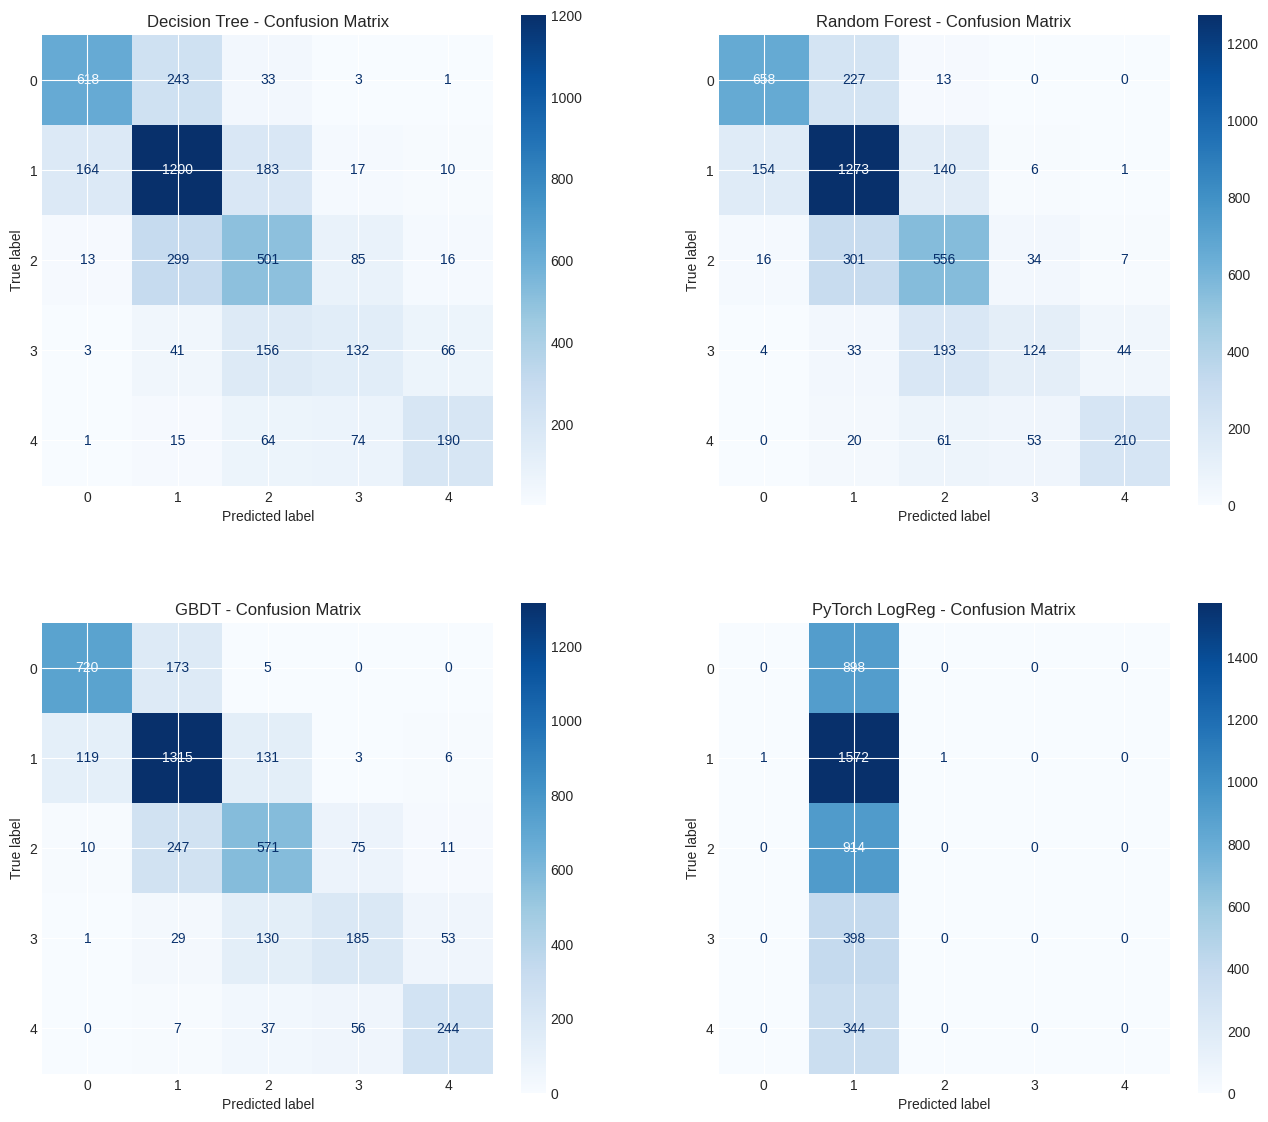

In [225]:
# Plot confusion matrices for all classification models
models_for_cm = [
    ('Decision Tree', dt_clf_test_pred),
    ('Random Forest', rf_clf_test_pred),
    ('GBDT', gbdt_test_pred),
    ('PyTorch LogReg', pytorch_lr_test_pred)
]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (name, predictions) in enumerate(models_for_cm):
    cm = confusion_matrix(y_test_clf, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name} - Confusion Matrix')

plt.show()

### 6.4 Classification Reports

In [226]:
for name, predictions in models_for_cm:
    print(f"\n{name}:")
    print("="*60)
    print(classification_report(y_test_clf, predictions,
                                target_names=[f'Class {i}' for i in range(N_BINS)],
                                zero_division=0))


Decision Tree:
              precision    recall  f1-score   support

     Class 0       0.77      0.69      0.73       898
     Class 1       0.67      0.76      0.71      1574
     Class 2       0.53      0.55      0.54       914
     Class 3       0.42      0.33      0.37       398
     Class 4       0.67      0.55      0.61       344

    accuracy                           0.64      4128
   macro avg       0.61      0.58      0.59      4128
weighted avg       0.64      0.64      0.64      4128


Random Forest:
              precision    recall  f1-score   support

     Class 0       0.79      0.73      0.76       898
     Class 1       0.69      0.81      0.74      1574
     Class 2       0.58      0.61      0.59       914
     Class 3       0.57      0.31      0.40       398
     Class 4       0.80      0.61      0.69       344

    accuracy                           0.68      4128
   macro avg       0.69      0.61      0.64      4128
weighted avg       0.68      0.68      0.68  

### 6.5 Feature Importance Analysis

Random Forest Regressor - Top 10 Features:


,Feature,Importance
11,IncomePerRoom,0.351799
0,MedInc,0.152844
8,RoomsPerHousehold,0.141339
7,Longitude,0.069358
5,AveOccup,0.057307
6,Latitude,0.055739
1,HouseAge,0.038943
13,Lat_x_Long,0.030855
3,AveBedrms,0.021951
9,BedroomRatio,0.019489


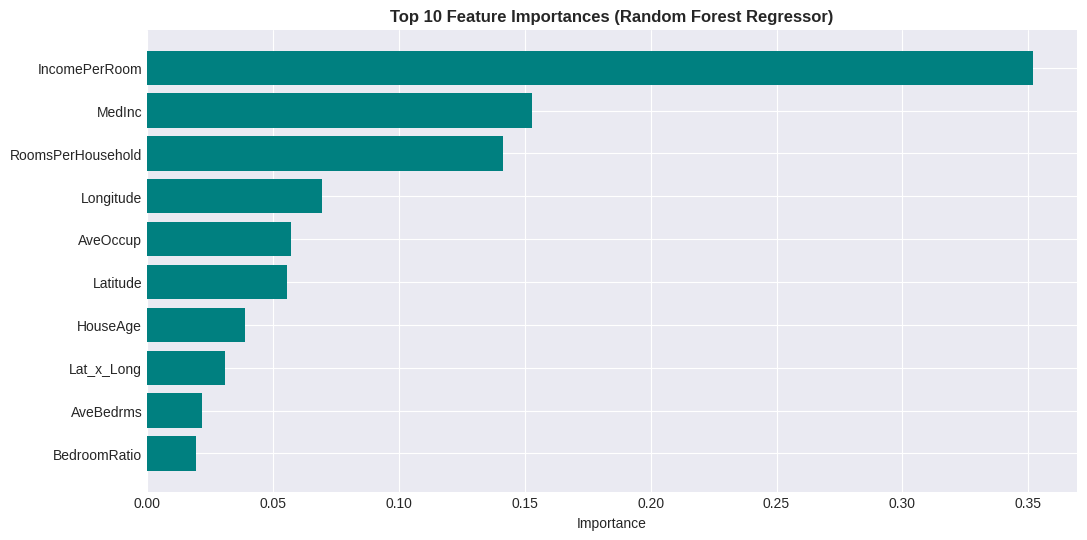

In [227]:
# Random Forest Regressor Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train_reg_scaled.columns,
    'Importance': rf_reg_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Regressor - Top 10 Features:")
display(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='teal')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest Regressor)', fontweight='bold')
plt.gca().invert_yaxis()
plt.show()


### 6.6 Actual vs Predicted (Regression)

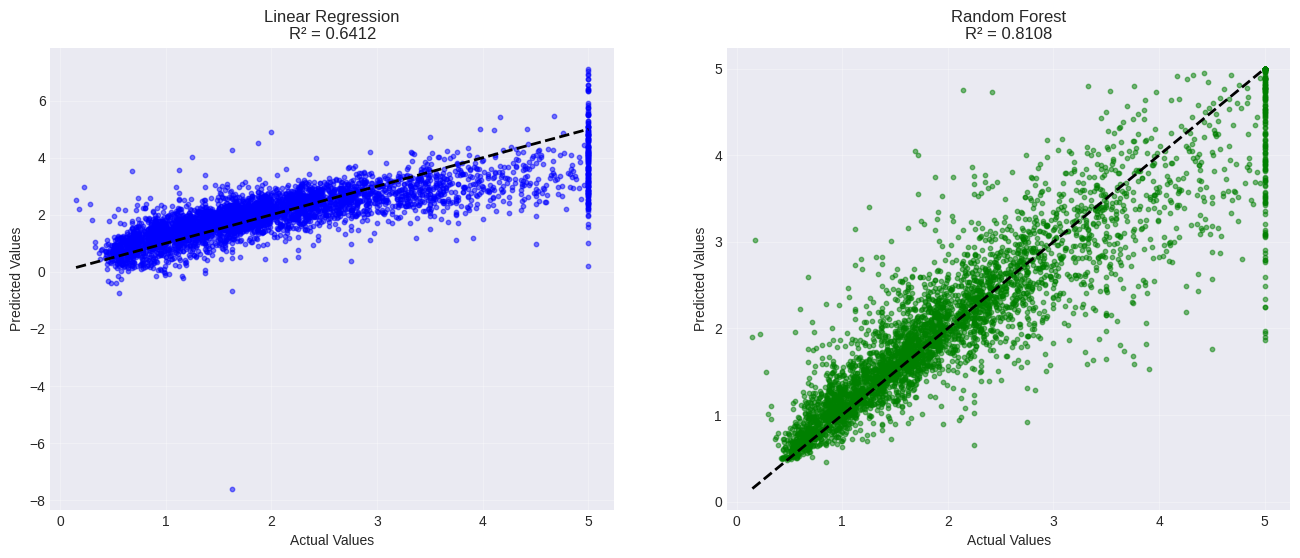

In [228]:
# Plot actual vs predicted for regression models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models_reg_plot = [
    ('Linear Regression', lr_test_pred, 'blue'),
    ('Random Forest', rf_reg_test_pred, 'green')
]

for idx, (name, pred, color) in enumerate(models_reg_plot):
    axes[idx].scatter(y_test_reg, pred, alpha=0.5, s=10, color=color)
    axes[idx].plot([y_test_reg.min(), y_test_reg.max()],
                   [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    r2 = r2_score(y_test_reg, pred)
    axes[idx].set_title(f'{name}\nR² = {r2:.4f}')
    axes[idx].grid(True, alpha=0.3)

plt.show()


### 6.7 Error Analysis

Top 10 Worst Predictions (Random Forest Regressor):


,Actual,Predicted,Error
9,5.00001,1.869643,3.130367
8,5.00001,1.894982,3.105028
7,5.00001,1.947841,3.052169
6,5.00001,1.967530,3.032480
5,0.17500,3.025600,2.850600
4,5.00001,2.241652,2.758358
3,5.00001,2.247175,2.752835
2,4.50000,1.760993,2.739007
1,5.00001,2.342254,2.657756
0,2.13900,4.752007,2.613007



Error Statistics:
Mean Absolute Error: 0.3250
Median Absolute Error: 0.2023
90th Percentile Error: 0.7675
95th Percentile Error: 1.0940


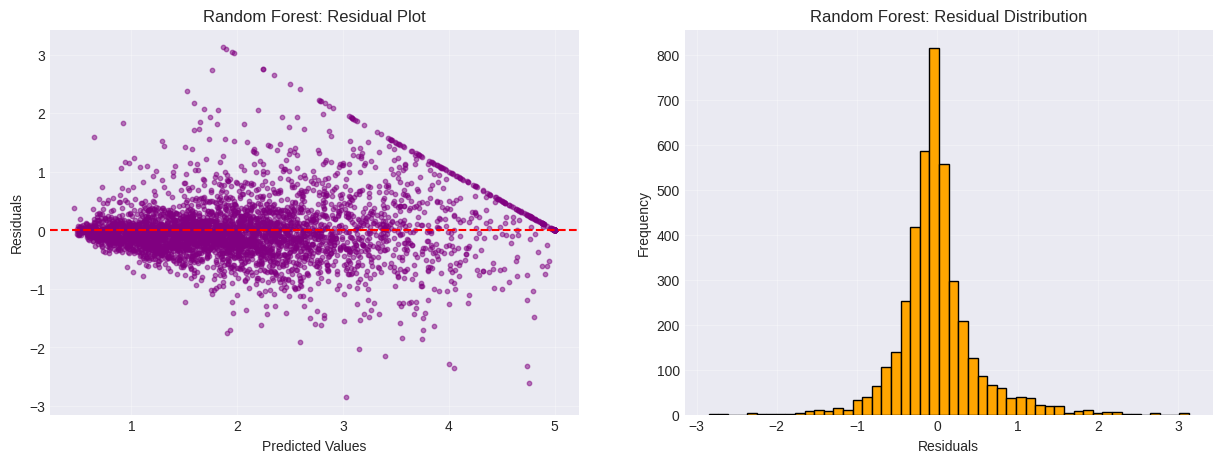

In [229]:
# Analyze errors for best regression model (Random Forest)
rf_errors = np.abs(y_test_reg.values - rf_reg_test_pred)
worst_indices = np.argsort(rf_errors)[-10:]

worst_predictions = pd.DataFrame({
    'Actual': y_test_reg.values[worst_indices],
    'Predicted': rf_reg_test_pred[worst_indices],
    'Error': rf_errors[worst_indices]
})

print("Top 10 Worst Predictions (Random Forest Regressor):")
display(worst_predictions.sort_values('Error', ascending=False))

print("\nError Statistics:")
print(f"Mean Absolute Error: {np.mean(rf_errors):.4f}")
print(f"Median Absolute Error: {np.median(rf_errors):.4f}")
print(f"90th Percentile Error: {np.percentile(rf_errors, 90):.4f}")
print(f"95th Percentile Error: {np.percentile(rf_errors, 95):.4f}")

# Plot residuals
residuals = y_test_reg.values - rf_reg_test_pred
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual plot
axes[0].scatter(rf_reg_test_pred, residuals, alpha=0.5, s=10, color='purple')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Random Forest: Residual Plot')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', color='orange')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Random Forest: Residual Distribution')
axes[1].grid(True, alpha=0.3)

plt.show()

---
## 7. Results & Insights
Summarize findings and provide recommendations.

### 7.2 Key Findings

### 7.3 Model Limitations

1. Data Limitations:   
• Dataset from 1990 - may not reflect current housing market   
• Limited to California geography   
• Aggregated at district level, not individual houses   
• No recent market trends or economic indicators

2. Feature Limitations:   
• Missing important factors: school quality, crime rates, amenities   
• No time-series component   
• Geographic features simplified to lat/long coordinates

3. Binning Trade-offs:   
• Information loss when converting continuous to categorical   
• Arbitrary bin boundaries may not reflect natural groupings   
• Classification metrics differ from regression metrics4. Model-Specific Issues:   
• Decision trees prone to overfitting   • Random Forest lacks interpretability   
• GBDT sensitive to hyperparameters   
• PyTorch requires more code complexity

5. Deployment Considerations:   
• Models need retraining with current data   
• Feature scaling must be applied consistently   
• Should combine with domain expertise   
• Hyperparameter tuning could improve performance